<a href="https://colab.research.google.com/github/ranton256/classifying_concord/blob/main/supervised_ML_identify_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning - Identify Author


In [1]:
!pip install -q spacy

In [2]:
# you will need to download the spacy model for english.
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.0 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!which python

/Users/ranton/classifying_concord/.venv/bin/python


In [4]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
import spacy

## The Dataset
Our two datasets are constructed from two related works of 19th century American transcendentalism. These are both public domain.

1. [Essays by Ralph Waldo Emerson by Ralph Waldo Emerson](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F16643)
2. [Walden, and On The Duty Of Civil Disobedience by Henry David Thoreau](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F205)

These two authors had different writing styles but shared more than their philosophical interests—they were neighbors in Concord, Massachusetts.

These two works are also similar in length when formatted as plain text.

We will use spaCy to segment each work into sections of roughly 3 to 5 sentences each, then build a datafrom of the text including a label of 'emerson' or 'thoreau', then shuffle and split that into train and test sets for training some machine learning models to classify them by predicting which author they are from and compare the results.

We will also preprocess text to remove stopwords,and perform lemmatization.

In [6]:
emerson_txt_url = "https://www.gutenberg.org/ebooks/16643.txt.utf-8"
thoreau_txt_url = "https://www.gutenberg.org/ebooks/205.txt.utf-8"


In [7]:
import requests
from pathlib import Path

In [8]:
def download_file(url):
  local_filename = Path(url.split('/')[-1])
  result = requests.get(url)
  result.raise_for_status()
  with open(local_filename, "wb") as f:
      f.write(result.content)
  return local_filename

In [9]:
emerson_file = download_file(emerson_txt_url)
thoreau_file = download_file(thoreau_txt_url)

In [10]:
!head -n 50 {emerson_file}

The Project Gutenberg eBook of Essays by Ralph Waldo Emerson
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Essays by Ralph Waldo Emerson

Author: Ralph Waldo Emerson

Editor: Edna Henry Lee Turpin

Release date: September 4, 2005 [eBook #16643]
                Most recently updated: April 29, 2022

Language: English

Credits: Curtis A. Weyant, Sankar Viswanathan and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***




                                ESSAYS

                                  BY

                     

In [11]:
!head -n 50 {thoreau_file}

The Project Gutenberg eBook of Walden, and On The Duty Of Civil Disobedience
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Walden, and On The Duty Of Civil Disobedience

Author: Henry David Thoreau

Release date: January 1, 1995 [eBook #205]
                Most recently updated: September 19, 2024

Language: English

Credits: Judith Boss, and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***
WALDEN




and



ON THE DUTY OF CIVIL DISOBEDIENCE



by Henry David Thoreau


cover


Contents


 WALDEN

 Economy
 Where I Lived, and W

In [12]:
# Let's strip the frontmatter lines off the start of each file.
# remove each line preceding one that contains "START OF THE PROJECT GUTENBERG EBOOK "
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {emerson_file}
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {thoreau_file}

25:*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***
23:*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***


In [13]:
def trim_frontmatter(filename):
  with open(filename) as f:
    lines = f.readlines()

  n_trim_lines = 0
  for i, line in enumerate(lines):
    if "START OF THE PROJECT GUTENBERG EBOOK" in line:
      n_trim_lines = i + 1
      break

  trimmed_lines = lines[n_trim_lines:]
  trimmed_content = '\n'.join(trimmed_lines)
  new_filename = f"trimmed_{filename}"
  with open(new_filename, "w") as f:
    f.write(trimmed_content)
  return new_filename

In [14]:
trimmed_emerson_file = trim_frontmatter(emerson_file)
trimmed_thoreau_file = trim_frontmatter(thoreau_file)

In [15]:
!head {trimmed_emerson_file}
!head {trimmed_thoreau_file}









                                ESSAYS

WALDEN











In [16]:
from collections import deque
from random import randint
import itertools


In [17]:
nlp = spacy.load("en_core_web_sm")
# if you have an error here, make sure you ran the "!python -m spacy download en_core_web_sm" command in the earlier cell.

In [18]:
def segment_doc(filename):
  with open(filename) as f:
    text = f.read()
  doc = nlp(text)
  assert doc.has_annotation("SENT_START")

  sent_dq = deque()
  #it = doc.sents.__iter__()
  n = randint(3, 5)

  for sent in doc.sents:
    sent_dq.append(sent)
    if len(sent_dq) > n:
      sent_dq.popleft()
      snippet = " ".join(sent.text for sent in sent_dq)
      yield snippet
      n = randint(3, 5)
      sent_dq.clear()

In [19]:
import pandas as pd

In [20]:
def dataframe_from_file(file_path):
  segments = segment_doc(file_path)

  df = pd.DataFrame(segments, columns=["text"])
  return df


In [21]:
emerson_df = dataframe_from_file(trimmed_emerson_file)
emerson_df.to_csv("emerson.csv")
emerson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1068 non-null   object
dtypes: object(1)
memory usage: 8.5+ KB


In [22]:
emerson_df.head()

,text
0,The editors of the several volumes will be\n\n...
1,"As a school-boy he was quiet and retiring, rea..."
2,"He was always serene and\n\nthoughtful, impres..."
3,"As a preacher, Emerson was interesting,\n\ntho..."
4,"A\n\nconnoisseur in such matters, an old sexto..."


In [23]:

thoreau_df = dataframe_from_file(trimmed_thoreau_file)
thoreau_df.to_csv("thoreau.csv")
thoreau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    840 non-null    object
dtypes: object(1)
memory usage: 6.7+ KB


In [24]:
thoreau_df.head()

,text
0,I lived there two\n\nyears and two months. At ...
1,"In most books, the _I_, or first person,\n\nis..."
2,"As for the rest of my readers,\n\nthey will ac..."
3,What\n\nI have heard of Brahmins sitting expos...
4,Who made them\n\nserfs of the soil? Why should...


In [25]:
# combine and shuffle the datasets, using a consistent random seed.
from sklearn.utils import shuffle

d1 = emerson_df.copy()
d1["label"] = "emerson"

d2 = thoreau_df.copy()
d2["label"] = "thoreau"

combined_df = pd.concat([d1, d2])
combined_df = shuffle(combined_df, random_state=7919)
combined_df.to_csv("combined.csv")
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1908 entries, 469 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1908 non-null   object
 1   label   1908 non-null   object
dtypes: object(2)
memory usage: 44.7+ KB


,text,label
469,Nature does not cocker us:[458] we are childre...,emerson
834,INDEMNITY - You agree to indemnify and hold th...,thoreau
626,Let him see that as much wisdom may\n\nbe expe...,emerson
98,There is some of the same fitness in a\n\nman’...,thoreau
321,"When Winslow, afterward governor of the Plymou...",thoreau


## Now we have our dataset in combined.csv


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# you can start here if csv files were already created.
from sklearn.feature_extraction.text import TfidfVectorizer

/var/folders/jc/d3zkxmh531b0pwdxpxnqbbqh0000gn/T/ipykernel_7746/3711010374.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["label"], palette="rocket")


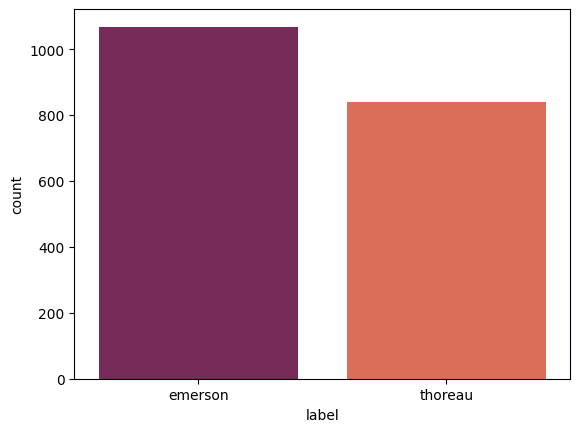

In [28]:
sns.countplot(x=combined_df["label"], palette="rocket")
plt.show()


In [29]:
%pip install -q wordcloud

Note: you may need to restart the kernel to use updated packages.


In [30]:
from spacy.lang.en import STOP_WORDS
my_stopwords = STOP_WORDS

', '.join(my_stopwords)

"namely, other, my, whoever, each, are, can, last, someone, another, themselves, 've, hers, therefore, ’m, several, already, beside, ever, yourself, they, indeed, had, may, under, between, do, give, down, so, been, we, you, whatever, regarding, hence, 're, done, seem, us, be, together, anything, behind, on, cannot, an, front, fifteen, with, side, should, of, make, how, were, yourselves, nobody, elsewhere, noone, keep, up, himself, until, before, ourselves, n’t, 'd, three, amongst, many, most, while, less, move, for, just, around, am, beforehand, thereafter, ours, onto, our, after, get, no, none, four, beyond, was, ca, that, there, during, why, from, as, moreover, nine, their, next, unless, ’ve, six, who, thru, above, amount, everywhere, further, seeming, ‘ve, all, except, would, nevertheless, nothing, whence, whereas, its, else, always, latter, somehow, mine, along, i, few, than, own, enough, too, nor, whose, ‘d, now, towards, itself, ’ll, 'm, into, those, when, therein, top, hereby, t

In [31]:
# Show wordcloud from each dataset.
from wordcloud import WordCloud


def plot_word_cloud(text_sections, title):
  cloud = WordCloud(background_color='black', stopwords=my_stopwords).generate(str(text_sections))
  fig = plt.figure(figsize=(12,8), facecolor='white')
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title, fontsize=48)
  plt.tight_layout(pad=0)
  plt.show()




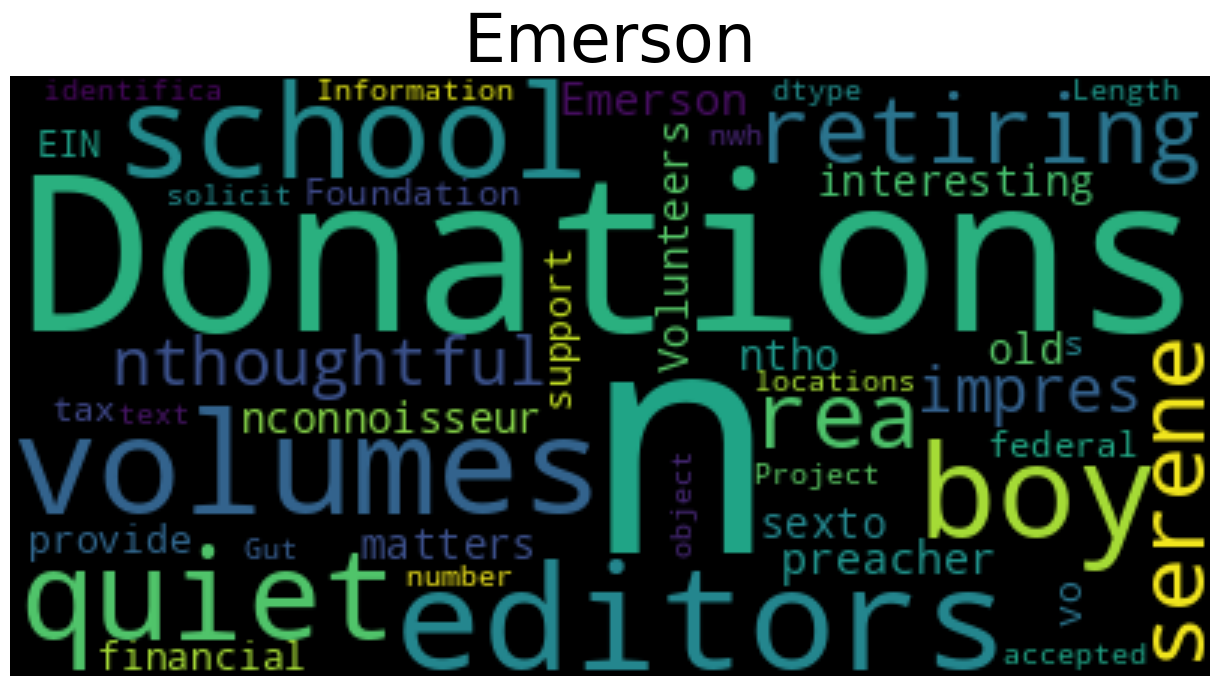

In [32]:
plot_word_cloud(emerson_df["text"], "Emerson")

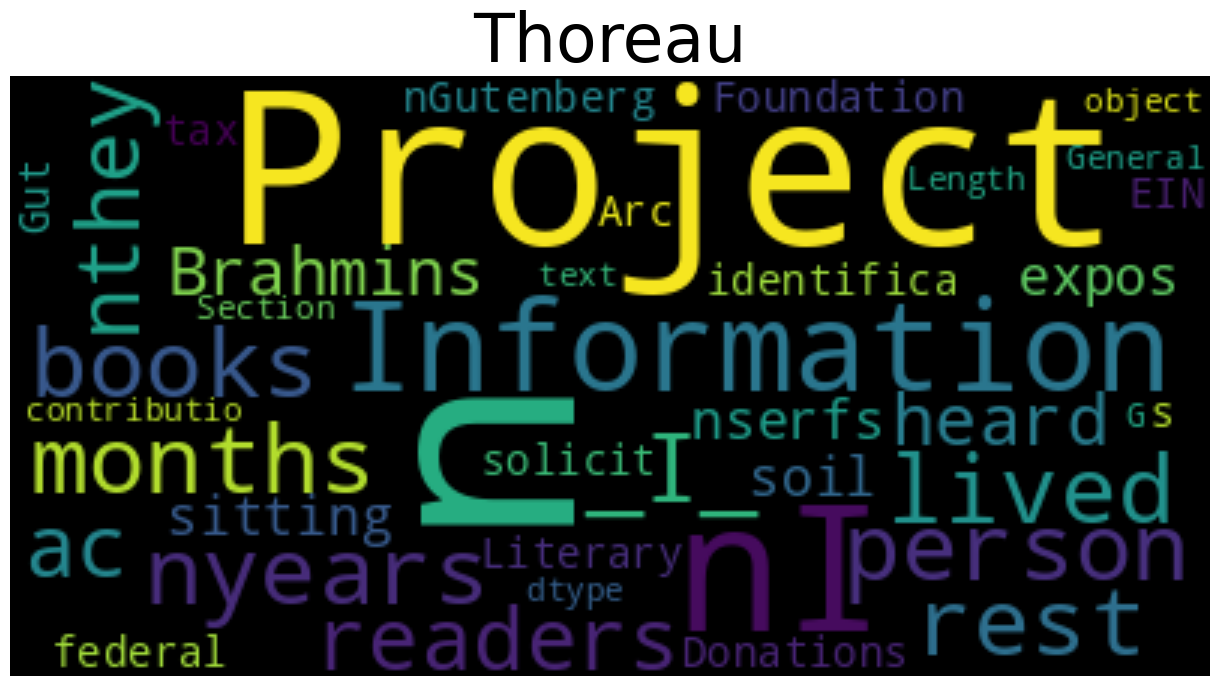

In [33]:
plot_word_cloud(thoreau_df["text"], "Thoreau")

In [34]:
# Preprocess text to remove stopwords, and perform lemmatization.

final_text = []
for index,entry in enumerate(combined_df['text']):
  doc = nlp(entry.lower())
  Final_words = []
  for word in doc:
    if not word.is_stop and not word.is_punct:
      Final_words.append(word.lemma_)
  final_text.append(' '.join(Final_words))



In [35]:
combined_df['final_text'] = final_text
combined_df.head()

,text,label,final_text
469,Nature does not cocker us:[458] we are childre...,emerson,nature cocker us:[458 child \n\n pet fond deal...
834,INDEMNITY - You agree to indemnify and hold th...,thoreau,indemnity agree indemnify hold foundation \n\n...
626,Let him see that as much wisdom may\n\nbe expe...,emerson,let wisdom \n\n expend private economy empire ...
98,There is some of the same fitness in a\n\nman’...,thoreau,fitness \n\n man build house bird build \n\n n...
321,"When Winslow, afterward governor of the Plymou...",thoreau,winslow afterward governor plymouth colony go ...


In [36]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df["final_text"])
y = combined_df["label"]


In [43]:
# split our data into train and test sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4909)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (1530, 11914)
y_train: (1530,)
x_test: (383, 11914)
y_test: (383,)


In [44]:
from sklearn.linear_model import LogisticRegression


In [36]:
# -2 for n_jobs is all but one CPU available.
lr_model = LogisticRegression(solver='saga', random_state=8102, n_jobs=-2)

lr_model.fit(x_train, y_train)

LogisticRegression(n_jobs=-2, random_state=8102, solver='saga')

In [71]:
y_pred = lr_model.predict(x_test)

NameError: name 'lr_model' is not defined

In [70]:
from sklearn.metrics import f1_score

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Markdown, display

def show_metrics(y_test, y_pred, model_name):
  display(Markdown(f"# {model_name}"))

  print(classification_report(y_test,y_pred))
  print("Test accuracy:", accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)

  labels = ["emerson", "thoreau"]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# Logistic Regression

              precision    recall  f1-score   support

     emerson       0.84      0.90      0.87       210
     thoreau       0.87      0.79      0.83       173

    accuracy                           0.85       383
   macro avg       0.85      0.85      0.85       383
weighted avg       0.85      0.85      0.85       383

Test accuracy: 0.8511749347258486


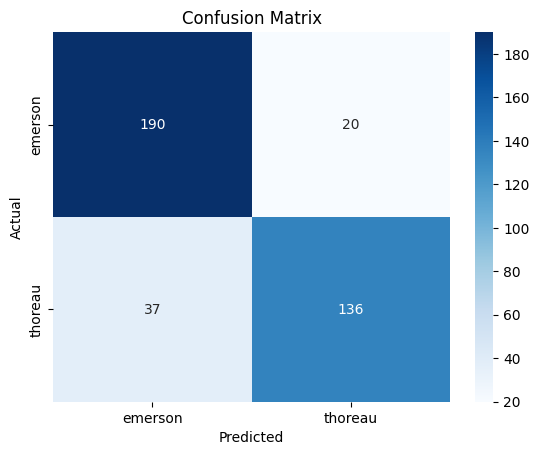

In [39]:
show_metrics(y_test, y_pred, "Logistic Regression")

In [40]:
# Let's compare that to random forests.


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)


RandomForestClassifier()

In [41]:
y_pred_rf = rf.predict(x_test)

# Random Forest

              precision    recall  f1-score   support

     emerson       0.82      0.88      0.85       210
     thoreau       0.84      0.76      0.80       173

    accuracy                           0.83       383
   macro avg       0.83      0.82      0.82       383
weighted avg       0.83      0.83      0.82       383

Test accuracy: 0.825065274151436


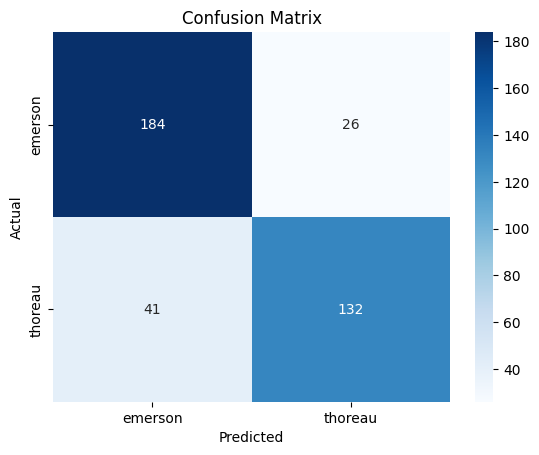

In [42]:
show_metrics(y_test, y_pred_rf, "Random Forest")

In [43]:
from sklearn import svm

In [44]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train,y_train)
clf

SVC()

In [45]:
y_pred_svm = clf.predict(x_test)

# SVM

              precision    recall  f1-score   support

     emerson       0.84      0.90      0.87       210
     thoreau       0.87      0.80      0.83       173

    accuracy                           0.86       383
   macro avg       0.86      0.85      0.85       383
weighted avg       0.86      0.86      0.86       383

Test accuracy: 0.856396866840731


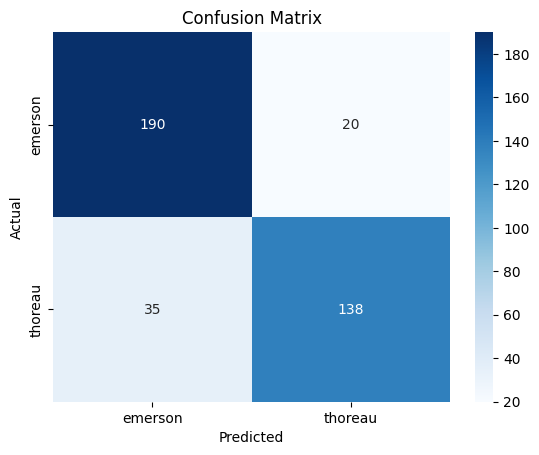

In [46]:
show_metrics(y_test, y_pred_svm, "SVM")

In [47]:
%pip install -q transformers

In [ ]:
%pip install -q torch

In [48]:
import torch

In [49]:
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [50]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_token_type_ids = False, padding="max_length", truncation=True)

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [51]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(combined_df["text"], combined_df["label"], test_size=0.2, random_state=4909)
print(f"x_train_s: {x_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"x_test_s: {x_test_s.shape}")
print(f"y_test_s: {y_test_s.shape}")


x_train_s: (1528,)
y_train_s: (1528,)
x_test_s: (383,)
y_test_s: (383,)


In [52]:
x_train_tok = tokenizer(x_train_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_tok = y_train_s.tolist()

x_test_tok = tokenizer(x_test_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_tok = y_test_s.tolist()


In [53]:
x_train_tok[0:2]

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [54]:

print(x_train_tok.keys())


#move onto device (GPU)
x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-54-cbedc1b8b59f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
<ipython-input-54-cbedc1b8b59f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}


In [55]:
with torch.no_grad():
  hidden_train = model(**x_train_tok)
  hidden_test = model(**x_test_tok)

# Get the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [56]:
x_train_db = cls_train.to("cpu")
# y_train_tok

x_test_db = cls_test.to("cpu")
# y_test_tok


In [81]:
lr_model2 = LogisticRegression(C=1, solver='saga', random_state=8102, n_jobs=-2, max_iter=10_000)

lr_model2.fit(x_train_db,y_train_tok)

# This does not converge, with the settings used for TF-DF
# ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# So we adjusting max_iter and experimented with C (regulation strength).

y_pred = lr_model2.predict(x_test_db)


# Logistic Regression on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.91      0.91      0.91       210
     thoreau       0.90      0.89      0.89       173

    accuracy                           0.90       383
   macro avg       0.90      0.90      0.90       383
weighted avg       0.90      0.90      0.90       383

Test accuracy: 0.9033942558746736


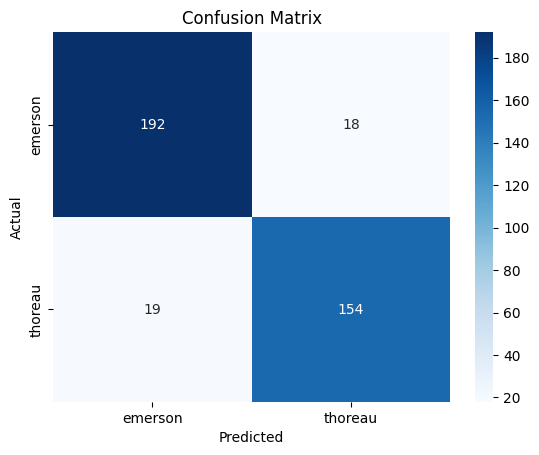

In [58]:
show_metrics(y_test_tok, y_pred, "Logistic Regression on DistilBERT hidden states")

In [59]:
rf = RandomForestClassifier()
rf.fit(x_train_db,y_train_tok)

rf.score(x_test_db,y_test_tok)

y_pred_rf = rf.predict(x_test_db)

# Random Forest on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.86      0.90      0.88       210
     thoreau       0.87      0.82      0.84       173

    accuracy                           0.86       383
   macro avg       0.86      0.86      0.86       383
weighted avg       0.86      0.86      0.86       383

Test accuracy: 0.8616187989556136


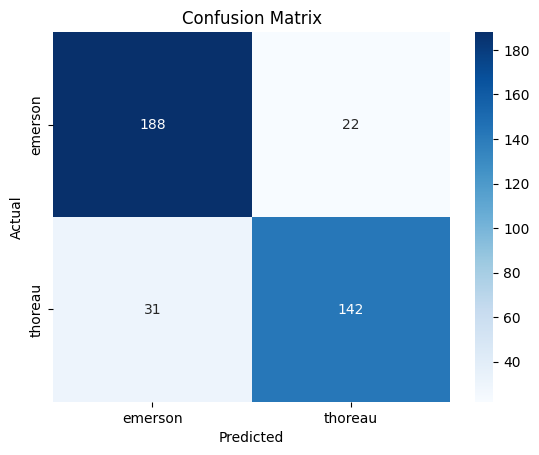

In [60]:
show_metrics(y_test_tok, y_pred_rf, "Random Forest on DistilBERT hidden states")

In [61]:
from sklearn import svm

In [62]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train_db,y_train_tok)

y_pred_svm = clf.predict(x_test_db)

# SVM on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.88      0.92      0.90       210
     thoreau       0.90      0.85      0.87       173

    accuracy                           0.89       383
   macro avg       0.89      0.88      0.89       383
weighted avg       0.89      0.89      0.89       383

Test accuracy: 0.8877284595300261


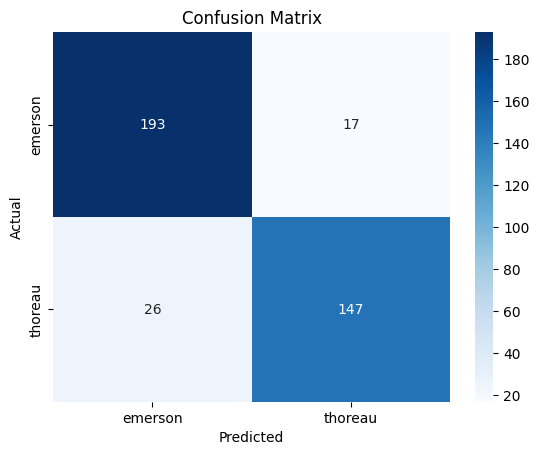

In [63]:
show_metrics(y_test_tok, y_pred_svm, "SVM on DistilBERT hidden states")

In [64]:
from transformers import DistilBertForSequenceClassification

# Define the model with random weights, suitable for binary classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
# we already have the appropriate tokenizer from before.



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# create our optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [66]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/491.2 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/116.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/183.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/143.5 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/194.8 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform

In [67]:
from sklearn import preprocessing

# Create a copy of our dataframe
trans_df = combined_df.copy()

# drop the preprocessed text column which we aren't using.
trans_df.drop("final_text", axis=1, inplace=True)

# transform our labels into numeric values.
le = preprocessing.LabelEncoder()
my_labels = trans_df["label"].tolist()
le.fit(my_labels)

my_cat_labels = le.classes_
trans_df["label"] = le.transform(trans_df["label"])

print(f"{my_cat_labels=}")

trans_df.info()
trans_df.describe()
trans_df.head()


my_cat_labels=array(['emerson', 'thoreau'], dtype='<U7')
<class 'pandas.core.frame.DataFrame'>
Index: 1911 entries, 153 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1911 non-null   object
 1   label   1911 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.8+ KB


,text,label
153,During this fast they abstain from the\n\ngrat...,1
638,"The life of man is a self-evolving circle,[696...",0
66,But perhaps a man is not required to bury hims...,1
409,Fine manners[398] show\n\nthemselves formidabl...,0
201,We must learn to reawaken and keep ourselves a...,1


In [68]:
from datasets import Dataset
from transformers import AutoTokenizer

# for simplicity, we are just splitting the dataset again.
train_df, test_df = train_test_split(trans_df, test_size=0.2, random_state=4909)



train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/1528 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

In [69]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch"
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-69-c2f16bbd5fc2>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ranton (ranton-fieldjay-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.319800,0.506422
2,0.205200,0.271532
3,0.110500,0.523318
4,0.065200,0.333783
5,0.039800,0.442241


TrainOutput(global_step=955, training_loss=0.1480980508614585, metrics={'train_runtime': 112.7924, 'train_samples_per_second': 67.735, 'train_steps_per_second': 8.467, 'total_flos': 434145340670208.0, 'train_loss': 0.1480980508614585, 'epoch': 5.0})

In [70]:
# Save the model.
trainer.save_model('model')

In [71]:
# This is how you can load the model.

# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("./model")

In [72]:
def predictor(text):
  #inputs = tokenizer(text, return_tensors="pt")
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

  with torch.no_grad():
      logits = model(**inputs).logits
  predictions = torch.argmax(logits, dim=-1)
  return predictions


In [73]:
x_test_trans = test_dataset["text"]
y_test_trans = test_dataset["label"]

# sanity test a few inference inputs.
for txt, lbl in zip(x_test_trans[:5], y_test_trans[:5]):
  pred = predictor( txt)
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

<ipython-input-72-118abc29aba2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


thoreau: pred=thoreau, txt='He should have\n\ngone up garret at once. “What!” exclaim a million Irishmen starting up\n\nfrom all the shanties in the land, “is not this railroad which we have\n\nbuilt a good thing?” Yes, I answer, _comparatively_ good, that is, you\n\nmight have done worse; but I wish, as you are brothers of mine, that\n\nyou could have spent your time better than digging in this dirt.\n\n\n\n\n\n\n\n'
thoreau: pred=thoreau, txt='The exact cost of my house, paying the usual price\n\nfor such materials as I used, but not counting the work, all of which\n\nwas done by myself, was as follows; and I give the details because very\n\nfew are able to tell exactly what their houses cost, and fewer still,\n\nif any, the separate cost of the various materials which compose them:—\n\n\n\n\n\n    Boards.......................... $ 8.03½, mostly shanty boards.\n\n     Refuse shingles for roof sides,..  4.00\n\n    Laths,...........................  1.25\n\n    Two second-hand window

In [74]:
y_pred_trans = [predictor(txt) for txt in x_test_trans]

for txt, lbl, pred in zip(x_test_trans[:5], y_test_trans[:5], y_pred_trans[:5]):
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")


<ipython-input-72-118abc29aba2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


thoreau: pred=thoreau, txt='He should have\n\ngone up garret at once. “What!” exclaim a million Irishmen starting up\n\nfrom all the shanties in the land, “is not this railroad which we have\n\nbuilt a good thing?” Yes, I answer, _comparatively_ good, that is, you\n\nmight have done worse; but I wish, as you are brothers of mine, that\n\nyou could have spent your time better than digging in this dirt.\n\n\n\n\n\n\n\n'
thoreau: pred=thoreau, txt='The exact cost of my house, paying the usual price\n\nfor such materials as I used, but not counting the work, all of which\n\nwas done by myself, was as follows; and I give the details because very\n\nfew are able to tell exactly what their houses cost, and fewer still,\n\nif any, the separate cost of the various materials which compose them:—\n\n\n\n\n\n    Boards.......................... $ 8.03½, mostly shanty boards.\n\n     Refuse shingles for roof sides,..  4.00\n\n    Laths,...........................  1.25\n\n    Two second-hand window

In [75]:
y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]

<ipython-input-75-29869180259a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]


In [76]:
y_test_trans = [torch.tensor(v).cpu() for v in y_test_trans]

# Fine-tuned DistilBERT

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       210
           1       0.91      0.91      0.91       173

    accuracy                           0.92       383
   macro avg       0.92      0.92      0.92       383
weighted avg       0.92      0.92      0.92       383

Test accuracy: 0.9216710182767625


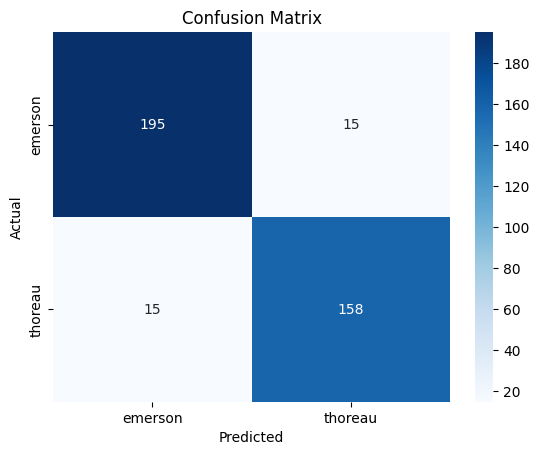

In [77]:
show_metrics(y_pred_trans, y_test_trans, "Fine-tuned DistilBERT")

## Let's check out the test samples that are misclassified.

In [78]:
def scalar_from_tensor(t):
  if t.dim() == 0:
    return t.item()
  elif t.dim() == 1:
    return t[0].item()
  else:
    raise ValueError(f"Unexpected tensor dimension: {t.dim()}")


In [79]:

y_test_trans = [scalar_from_tensor(t) for t in y_test_trans]
y_pred_trans = [scalar_from_tensor(t) for t in y_pred_trans]

print(f"y_test_trans: {y_test_trans[:5]}")
print(f"y_pred_trans: {y_pred_trans[:5]}")


y_test_trans: [1, 1, 0, 1, 1]
y_pred_trans: [1, 1, 0, 1, 1]


In [80]:
print("my_cat_labels")

rows = []
for i, (txt, lbl, pred) in enumerate(zip(x_test_trans, y_test_trans, y_pred_trans)):
  if lbl != pred:
    print(f"{lbl=},{pred=}")
    row =(my_cat_labels[lbl], my_cat_labels[pred], txt)
    print(f"{row=}")
    rows.append(row)

n_miss = len(rows)
print(f"Count of misclassified = {n_miss}")
misclassified_df = pd.DataFrame(rows, columns=["actual", "predicted", "text"])
misclassified_df.head(n_miss)


my_cat_labels
lbl=1,pred=0
row=(np.str_('thoreau'), np.str_('emerson'), '1.F.6. INDEMNITY - You agree to indemnify and hold the Foundation, the\n\ntrademark owner, any agent or employee of the Foundation, anyone\n\nproviding copies of Project Gutenberg™ electronic works in\n\naccordance with this agreement, and any volunteers associated with the\n\nproduction, promotion and distribution of Project Gutenberg™\n\nelectronic works, harmless from all liability, costs and expenses,\n\nincluding legal fees, that arise directly or indirectly from any of\n\nthe following which you do or cause to occur: (a) distribution of this\n\nor any Project Gutenberg™ work, (b) alteration, modification, or\n\nadditions or deletions to any Project Gutenberg™ work, and (c) any\n\nDefect you cause.\n\n\n\n Section 2.')
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'The city is recruited from the country. In the year\n\n1805, it is said, every legitimate monarch in Europe was imbecile. The\n\ncity 

,actual,predicted,text
0,thoreau,emerson,1.F.6. INDEMNITY - You agree to indemnify and ...
1,emerson,thoreau,The city is recruited from the country. In the...
2,thoreau,emerson,The\n\nsuccess of great scholars and thinkers ...
3,emerson,thoreau,If you discover a\n\ndefect in this electronic...
4,emerson,thoreau,"Do not charge a fee for access to, viewing, di..."
5,thoreau,emerson,"Comparatively, he is always strong, original, ..."
6,emerson,thoreau,It\n\nexists because of the efforts of hundred...
7,emerson,thoreau,and what a compensation for the\n\nshortness o...
8,thoreau,emerson,How much\n\nmore admirable the Bhagvat-Geeta t...
9,emerson,thoreau,You may use this eBook for nearly any purpose ...


## Postscript - Few short learning with a modern LLM

Another technique that is used recently is to use a few-shot learning to inject examples as context into an existing LLM model.


In [81]:
# choose some examples of each author from our training set.
import re
thoreau_samples = combined_df[ combined_df["label"] == "thoreau"].sample(3, random_state=7809)
emerson_samples = combined_df[ combined_df["label"] == "emerson"].sample(3, random_state=997)

# print(f"Thoreau sample: {thoreau_samples}")
# print(f"Emerson sample: {emerson_samples}")

emerson_samples_array = emerson_samples['text'].to_list()
thoreau_samples_array = thoreau_samples['text'].to_list()

emerson_samples_array = [s.strip() for s in emerson_samples_array]
thoreau_samples_array = [s.strip() for s in thoreau_samples_array]

# replace multiple newlines with a single newline
emerson_samples_array = [re.sub(r'\n+', '\n', sample) for sample in emerson_samples_array]
thoreau_samples_array = [re.sub(r'\n+', '\n', sample) for sample in thoreau_samples_array]

print("======Emerson samples:======\n")
for idx, sample in enumerate(emerson_samples_array):
    print(f"{idx+1}: {sample}\n")

print("======Thoreau samples:======\n")
for idx, sample in enumerate(thoreau_samples_array):
    print(f"{idx+1}: {sample}\n")


======Emerson samples:======

1: There is in woods and waters a certain enticement and
flattery, together with a failure to yield a present satisfaction.
 This disappointment is felt in every landscape. I have seen the
softness and beauty of the summer clouds floating feathery overhead,
enjoying, as it seemed, their height and privilege of motion, whilst
yet they appeared not so much the drapery of this place and hour, as
fore-looking to such pavilions and gardens of festivity beyond.

2: [Footnote 36: Plato (429-347 B.C.). One of the most illustrious
philosophers of all time. Probably no other philosopher has
contributed so much as Plato to the moral and intellectual training of
the human race.

3: [Footnote 247: Doric, the oldest, strongest, and simplest of the three
styles of Grecian architecture.]
 [Footnote 248: Gothic, a pointed style of architecture, prevalent in
western Europe in the latter part of the middle ages.]
 [Footnote 249: Never imitate.

======Thoreau samples:======



In [82]:
# We also need our prompt template 
prompt_template = """
You are an expert literary analyst. Your task is to classify whether a given text was written by {author1} or {author2}.

Here are some example texts from each author:

{author1} examples:
{author1_examples}

{author2} examples:
{author2_examples}

Based on these examples and your knowledge of their writing styles, analyze the following text and determine whether it was written by {author1} or {author2}:

Text to classify:
{text_to_classify}

Provide your classification and a brief explanation of your reasoning.
"""


In [83]:
def generate_prompt(text, author1, author2):    
    prompt_text = prompt_template.format(author1=author1, author2=author2, author1_examples=emerson_samples_array, author2_examples=thoreau_samples_array, text_to_classify=text)
    return prompt_text


In [84]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Now that we have our samples, we can inject them into an LLM.
# we will use Hugging Face's transformers library to inject the samples into the model.


# this model is small but accepts longer input sequences than BERT/DistilBERT.
model_name = "microsoft/Phi-3-mini-4k-instruct"

dev_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    id2label={0: "emerson", 1: "thoreau"},
    label2id={"emerson": 0, "thoreau": 1}
    ).to(device)

# get the tokenizer for the model.
tokenizer = AutoTokenizer.from_pretrained(model_name)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
# Use the model to predict the samples.
import torch

def classify_text(text, author1, author2):
    prompt_text = generate_prompt(text, author1, author2)
    inputs = tokenizer(prompt_text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

    output_logits = outputs.logits
    predicted_class_id = torch.argmax(output_logits, dim=1).item()
    predicted_class_label = model.config.id2label[predicted_class_id]
    predicted_probability = torch.softmax(output_logits, dim=1).max().item()

    return predicted_class_label, predicted_probability

In [ ]:
# let's try a few examples.

samples = combined_df.sample(3, random_state=4909)

for cnt, (idx, sample) in enumerate(samples.iterrows()):
    print(f"Example {cnt+1}:")
    print(f"Text: {sample['text']}")
    predicted_label, predicted_probability = classify_text(sample['text'], "Emerson", "Thoreau")
    print(f"Prediction: {predicted_label} ({predicted_probability:.2f})")
    print(f"Actual: {sample['label']}")
    print("-" * 80)
    print("\n")

Example 1:
Text: I was as near being

resolved into the essence of things as ever I was in my life. I fear my

thoughts will not come back to me. If it would do any good, I would

whistle for them.
Prediction: thoreau (0.96)
Actual: thoreau
--------------------------------------------------------------------------------


Example 2:
Text: You may perhaps have some pleasant,

thrilling, glorious hours, even in a poor-house. The setting sun is

reflected from the windows of the alms-house as brightly as from the

rich man’s abode; the snow melts before its door as early in the

spring. I do not see but a quiet mind may live as contentedly there,

and have as cheering thoughts, as in a palace. The town’s poor seem to

me often to live the most independent lives of any. May be they are

simply great enough to receive without misgiving.


In [74]:
%pip install -q tqdm
from tqdm import tqdm


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#A run over the whole dataset

# since we haven't trained the model, we don't really need to split the dataset.

MAX_SAMPLES = 100  # 100 samples is enough to get a good idea of the performance.

texts = combined_df["text"].tolist()
y_actual_phi = combined_df["label"].tolist()


# use tqdm to show progress
y_pred_phi = [classify_text(text, "Emerson", "Thoreau")[0] for text in tqdm(texts[:MAX_SAMPLES])]

y_actual_subset = y_actual_phi[:MAX_SAMPLES]
y_pred_subset = y_pred_phi


100%|██████████| 100/100 [4:41:54<00:00, 169.14s/it] 


# Few shot learning with Phi-3-mini-4k-instruct

              precision    recall  f1-score   support

     emerson       0.52      0.90      0.66        51
     thoreau       0.55      0.12      0.20        49

    accuracy                           0.52       100
   macro avg       0.53      0.51      0.43       100
weighted avg       0.53      0.52      0.43       100

Test accuracy: 0.52


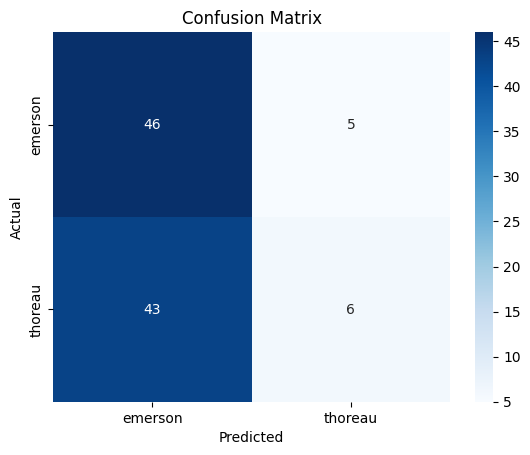

In [80]:
show_metrics(y_actual_subset, y_pred_subset, "Few shot learning with Phi-3-mini-4k-instruct")

In [ ]:
# Pretty terrible performance, actually.
